# Comparaison des 3 Méthodes de Segmentation

Ce notebook compare trois méthodes de segmentation sur des images de lésions cutanées :
1. **Otsu Multi-Canal** : Seuillage automatique d'Otsu sur plusieurs canaux de couleur
2. **LBP Clustering** : Local Binary Patterns avec clustering k-means
3. **Statistical Region Merging (SRM)** : Fusion de régions basée sur des critères statistiques

## Imports et Fonctions Utilitaires

In [2]:
# IMPORTS 
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color
from skimage.filters import gaussian
from skimage.morphology import disk, binary_opening, convex_hull_image
from scipy.ndimage import binary_fill_holes, gaussian_filter
from sklearn.cluster import KMeans
from collections import Counter
import os

print("Imports réussis")

Imports réussis


## Fonctions Communes

## Fonctions de Prétraitement

Ces fonctions permettent de :
1. **Supprimer le cadre noir** autour des images dermoscopiques
2. **Retirer les poils** de l'image avec la méthode DualRazor

In [3]:
import numpy as np
import cv2
from scipy import interpolate
from scipy.ndimage import convolve
import skimage
from skimage import io, morphology, filters
from skimage.filters import threshold_otsu
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import os

# CADRE / ISOLATE CIRCLE (from crop.py) 

def isolate_dermato_circle_adaptive(
    img,
    thresh_circle=60,          # seuil pour trouver le disque clair
    shrink_factor=0.9,         # pour enlever un peu le bord sombre
    crop=True,
    border_dark_thresh=30,     # seuil "noir" pour les bords
    border_ratio_trigger=0.2,  # % de pixels noirs sur les bords pour déclencher le cercle
    border_width_ratio=0.05    # largeur relative de la bande de bord (5%)
):
    """
    img : image RGB (np.ndarray, HxWx3)

    Retourne : 
        - img_out : image RGB avec le cercle isolé (et éventuellement croppée)
        - mask_out : masque 0/255 correspondant au cercle
    """

    h, w = img.shape[:2]
    # ICI on suppose que l'image est RGB
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Vérifier s'il y a vraiment un cadre noir
    bw = int(min(h, w) * border_width_ratio)
    border_mask = np.zeros_like(gray, dtype=bool)
    border_mask[:bw, :] = True      # haut
    border_mask[-bw:, :] = True     # bas
    border_mask[:, :bw] = True      # gauche
    border_mask[:, -bw:] = True     # droite

    dark_border = (gray < border_dark_thresh) & border_mask
    dark_ratio = dark_border.sum() / border_mask.sum()

    # Si peu de pixels vraiment noirs sur les bords -> pas de cercle
    if dark_ratio < border_ratio_trigger:
        mask_full = np.ones((h, w), dtype=np.uint8) * 255
        return img.copy(), mask_full

    # Détection du disque clair 
    _, mask = cv2.threshold(gray, thresh_circle, 255, cv2.THRESH_BINARY)

    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(mask)
    if num_labels <= 1:
        mask_full = np.ones((h, w), dtype=np.uint8) * 255
        return img.copy(), mask_full

    areas = stats[1:, cv2.CC_STAT_AREA]
    main_label = 1 + np.argmax(areas)
    mask_big = (labels == main_label).astype(np.uint8) * 255

    ys, xs = np.where(mask_big == 255)
    cx = int(xs.mean())
    cy = int(ys.mean())
    r = int(np.sqrt(((xs - cx) ** 2 + (ys - cy) ** 2).max()))
    r = int(r * shrink_factor)

    Y, X = np.ogrid[:h, :w]
    circle_mask = ((X - cx) ** 2 + (Y - cy) ** 2) <= r * r
    circle_mask = (circle_mask * 255).astype(np.uint8)

    output = img.copy()
    # On met le fond en blanc
    output[circle_mask == 0] = 255

    if crop:
        ys, xs = np.where(circle_mask == 255)
        top, bottom = ys.min(), ys.max() + 1
        left, right = xs.min(), xs.max() + 1
        output = output[top:bottom, left:right]
        circle_mask = circle_mask[top:bottom, left:right]

    return output, circle_mask


def matmax(img):

  """
  :param img : l'image RGB
  :return: tuple des masques (pour R, G et B de l'image) des pixels de poils
  """

  R = img[:,:,0]
  G = img[:,:,1]
  B = img[:,:,2]

  s0 = morphology.rectangle(50,10)
  s1 = morphology.rectangle(10,50)

  r0 = morphology.closing(R, footprint=s0)
  r1 = morphology.closing(R, footprint=s1)

  g0 = morphology.closing(G, footprint=s0)
  g1 = morphology.closing(G, footprint=s1)

  b0 = morphology.closing(B, footprint=s0)
  b1 = morphology.closing(B, footprint=s1)

  matmaxr = np.zeros(R.shape)
  matmaxg = np.zeros(R.shape)
  matmaxb = np.zeros(R.shape)
  nlin, ncol = R.shape

  for i in range(nlin):
    for j in range(ncol):
      matmaxr[i,j] = max(r0[i,j], r1[i,j])
      matmaxg[i,j] = max(g0[i,j], g1[i,j])
      matmaxb[i,j] = max(b0[i,j], b1[i,j])

  return (matmaxr, matmaxg, matmaxb)

def hair_mask(img, matmax):

  """
  :param img : l'image RGB
  :param matmax: tuple des trois masques de poils R, G et B
  :return: tuple des masques (pour R, G et B de l'image) des pixels de poils (avec des zones de poils élargies)
  """

  R = img[:,:,0]
  G = img[:,:,1]
  B = img[:,:,2]

  matmaxr, matmaxg, matmaxb = matmax
  Mr = np.zeros(matmaxr.shape)
  Mg = np.zeros(matmaxr.shape)
  Mb = np.zeros(matmaxr.shape)

  Mr[:,:] = np.abs(R[:,:]-matmaxr[:,:]) > 40
  Mg[:,:] = np.abs(G[:,:]-matmaxg[:,:]) > 40
  Mb[:,:] = np.abs(B[:,:]-matmaxb[:,:]) > 40

  square = morphology.rectangle(20, 20)
  Mr = morphology.binary_dilation(Mr, square)
  Mb = morphology.binary_dilation(Mb, square)
  Mg = morphology.binary_dilation(Mg, square)

  return (Mr, Mg, Mb)

def interpolate_missing_pixels(
        image: np.ndarray,
        mask: np.ndarray,
        method: str = 'nearest',
        fill_value: int = 0
):
    """
    :param image: a 2D image
    :param mask: a 2D boolean image, True indicates missing values
    :param method: interpolation method, one of
        'nearest', 'linear', 'cubic'.
    :param fill_value: which value to use for filling up data outside the
        convex hull of known pixel values.
        Default is 0, Has no effect for 'nearest'.
    :return: the image with missing values interpolated
    """
    
    h, w = image.shape[:2]
    xx, yy = np.meshgrid(np.arange(w), np.arange(h))

    known_x = xx[~mask]
    known_y = yy[~mask]
    known_v = image[~mask]
    missing_x = xx[mask]
    missing_y = yy[mask]

    interp_values = interpolate.griddata(
        (known_x, known_y), known_v, (missing_x, missing_y),
        method=method, fill_value=fill_value
    )

    interp_image = image.copy()
    interp_image[missing_y, missing_x] = interp_values

    return interp_image

def hairRemoval(img, mask):

  """
  :param img : l'image RGB
  :return: l'image sans les poils
  """
  
  matmax_ = matmax(img)
  (matmaxr, matmaxg, matmaxb) = matmax_
  (Mr, Mg, Mb) = hair_mask(img, matmax_)

  hairDetection = morphology.erosion(np.abs(img[:,:,0]-matmaxr), footprint=morphology.disk(12))
  if hairDetection.sum() / mask.sum() < 0.2:
    return img

  R = img[:,:,0]
  G = img[:,:,1]
  B = img[:,:,2]

  newR = interpolate_missing_pixels(R, Mr > 0)
  newB = interpolate_missing_pixels(B, Mb > 0)
  newG = interpolate_missing_pixels(G, Mg > 0)

  square = morphology.rectangle(20, 20)
  Rf = skimage.filters.median(newR, square)
  Gf = skimage.filters.median(newG, square)
  Bf = skimage.filters.median(newB, square)

  final_img = np.copy(img)
  final_img[:,:,0]=Rf
  final_img[:,:,1]=Gf
  final_img[:,:,2]=Bf

  return final_img

# PIPELINE COMPLETE DE PRÉTRAITEMENT

def preprocess_image(img_rgb, remove_frame=True, remove_hair=True, verbose=False):
    """
    Pipeline complet de prétraitement d'une image dermoscopique
    
    :param img_rgb: Image RGB en format numpy array (H, W, 3)
    :param remove_frame: Si True, retire le cadre noir
    :param remove_hair: Si True, retire les poils
    :param verbose: Si True, affiche les étapes
    :return: Image prétraitée en RGB
    """
    processed_img = img_rgb.copy()
    
    # Étape 1: Suppression du cadre noir
    if remove_frame:
        # isolate_dermato_circle_adaptive attend du RGB et renvoie du RGB
        img_cropped, mask_uint8 = isolate_dermato_circle_adaptive(processed_img, crop=True)
        processed_img = img_cropped
        if verbose:
            print("✓ Cadre noir supprimé")
    else:
        # Si on ne crop pas, on doit quand même avoir un masque pour hairRemoval
        # On suppose que tout est valide
        h, w = processed_img.shape[:2]
        mask_uint8 = np.ones((h, w), dtype=np.uint8) * 255
    
    # Étape 2: Suppression des poils
    if remove_hair:
        mask_bool = mask_uint8 > 0
        processed_img = hairRemoval(processed_img, mask_bool)
        if verbose:
            print("✓ Poils supprimés")
    
    return processed_img

print("Fonctions de prétraitement définies (Nouvelle version DualRazor)")

Fonctions de prétraitement définies (Nouvelle version DualRazor)


## Fonctions pour LBP Clustering

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
from skimage import io as skio
from skimage.morphology import convex_hull_image
from skimage.transform import rescale

def lbp_clustering_segmentation(img_rgb: np.ndarray, sigma: float = 3.0, disk_size: int = 3, verbose: bool = False) -> tuple:
    """
    Version OPTIMISÉE, CORRIGÉE et COMPATIBLE avec vos tests de debug.
    """
    from skimage.transform import resize
    from skimage.color import rgb2gray, rgb2lab, lab2rgb
    from skimage.feature import local_binary_pattern
    from sklearn.cluster import KMeans
    from skimage import morphology
    from skimage.filters import gaussian
    from skimage.morphology import convex_hull_image
    import matplotlib.pyplot as plt
    
    # 1. Redimensionnement (Vitesse x100)
    orig_h, orig_w = img_rgb.shape[:2]
    calc_size = (256, 256)
    img_small = resize(img_rgb, calc_size, anti_aliasing=True)
    
    # 2. LBP sur image réduite
    gray = rgb2gray(img_small)
    gray_u8 = (gray * 255).astype(np.uint8)
    radius = 3
    n_points = 8 * radius
    lbp = local_binary_pattern(gray_u8, n_points, radius, method='uniform')
    
    # Lissage pour visualisation
    smoothed_L = gaussian(gray, sigma=sigma)

    # 3. Clustering
    lab = rgb2lab(img_small)
    features = np.hstack([lab.reshape(-1, 3), lbp.reshape(-1, 1) * 0.5])
    
    kmeans = KMeans(n_clusters=2, n_init=3, max_iter=50, random_state=42)
    labels_small = kmeans.fit_predict(features)
    
    # Reconstruction des labels en image 2D (petite)
    mask_labels_small = labels_small.reshape(calc_size)
    
    # --- CORRECTION CRITIQUE POUR VOTRE ERREUR ---
    # On remet les labels à la taille originale pour que votre 'print' et vos plots fonctionnent
    mask_labels_full = resize(mask_labels_small, (orig_h, orig_w), order=0, mode='edge', anti_aliasing=False)
    full_labels_flat = mask_labels_full.flatten() # Format attendu par votre code existant
    
    # 4. Sélection de la lésion (Cluster le plus sombre)
    mean_val_0 = gray[mask_labels_small == 0].mean()
    mean_val_1 = gray[mask_labels_small == 1].mean()
    lesion_id = 1 if mean_val_1 < mean_val_0 else 0
    
    binary_mask_small = (mask_labels_small == lesion_id).astype(np.uint8)
    
    # 5. Nettoyage
    kernel = morphology.disk(disk_size)
    opened_mask = morphology.binary_opening(binary_mask_small, kernel)
    closed_mask = morphology.binary_closing(opened_mask, kernel)
    
    # Bords à 0
    border = 5
    cleaned_mask = closed_mask.copy()
    cleaned_mask[:border, :] = 0; cleaned_mask[-border:, :] = 0
    cleaned_mask[:, :border] = 0; cleaned_mask[:, -border:] = 0
    
    # 6. Masque final
    final_mask_resized = resize(cleaned_mask, (orig_h, orig_w), order=0, mode='edge', anti_aliasing=False)
    final_mask_resized = (final_mask_resized > 0.5).astype(np.uint8)
    
    # Plus grande composante
    from skimage.measure import label
    labeled = label(final_mask_resized)
    if labeled.max() > 0:
        areas = np.bincount(labeled.flat)[1:]
        largest_cc = 1 + np.argmax(areas)
        final_mask_cc = (labeled == largest_cc).astype(np.uint8)
    else:
        final_mask_cc = final_mask_resized

    # Remplissage des trous (taches noires dans taches blanches)
    from scipy.ndimage import binary_fill_holes
    final_mask_filled = binary_fill_holes(final_mask_cc).astype(np.uint8)

    # Convex Hull
    try:
        convex_hull = convex_hull_image(final_mask_filled)
    except:
        convex_hull = final_mask_filled

    # VISUALISATION PIPELINE COMPLETE
    fig, axes = plt.subplots(3, 4, figsize=(24, 18))
    plt.suptitle("Pipeline LBP Clustering (DÉTAILLÉ)", fontsize=20)
    
    # Ligne 1 : Prétraitements
    axes[0,0].imshow(img_rgb)
    axes[0,0].set_title("1. Originale (Prétraitée)")
    axes[0,0].axis('off')
    
    axes[0,1].imshow(img_small)
    axes[0,1].set_title("2. Redimensionnée (256x256)")
    axes[0,1].axis('off')
    
    axes[0,2].imshow(gray, cmap='gray')
    axes[0,2].set_title("3. Luminance (Gray)")
    axes[0,2].axis('off')

    axes[0,3].imshow(smoothed_L, cmap='gray')
    axes[0,3].set_title(f"4. Lissage Gaussien (sigma={sigma})")
    axes[0,3].axis('off')

    # Ligne 2 : Features & Clustering
    axes[1,0].imshow(lab[:,:,1], cmap='RdGy') # Canal A de Lab (souvent utile pour rougeur)
    axes[1,0].set_title("5. Espace Lab (Canal A)")
    axes[1,0].axis('off')

    axes[1,1].imshow(lbp, cmap='gray')
    axes[1,1].set_title("6. LBP Feature Map")
    axes[1,1].axis('off')
    
    axes[1,2].imshow(mask_labels_small, cmap='nipy_spectral')
    axes[1,2].set_title("7. K-Means Clusters")
    axes[1,2].axis('off')
    
    axes[1,3].imshow(binary_mask_small, cmap='gray')
    axes[1,3].set_title("8. Sélection Lésion (Sombre)")
    axes[1,3].axis('off')

    # Ligne 3 : Post-traitement
    axes[2,0].imshow(cleaned_mask, cmap='gray')
    axes[2,0].set_title("9. Nettoyage Morpho + Bords")
    axes[2,0].axis('off')

    axes[2,1].imshow(final_mask_cc, cmap='gray')
    axes[2,1].set_title("10. Plus Grande Composante")
    axes[2,1].axis('off')

    axes[2,2].imshow(final_mask_filled, cmap='gray')
    axes[2,2].set_title("11. Remplissage Trous (Final)")
    axes[2,2].axis('off')
    
    axes[2,3].imshow(final_mask_filled, cmap='gray')
    axes[2,3].imshow(convex_hull, cmap='Reds', alpha=0.3)
    axes[2,3].set_title("12. Convex Hull")
    axes[2,3].axis('off')
    
    plt.tight_layout()
    plt.savefig("lbp_pipeline.jpg")
    plt.close()
    print("Visualisation DÉTAILLÉE sauvegardée : lbp_pipeline.jpg")

    # On renvoie le dictionnaire COMPLET pour éviter le KeyError
    return final_mask_filled, convex_hull, {
        'cluster_labels': full_labels_flat,
        'luminance': gray,
        'lbp_codes': lbp,
        'smoothed_L': smoothed_L
    }

## Fonctions pour Otsu Multi-Canal

In [5]:
from skimage import filters, morphology, segmentation, color
from skimage.transform import resize
from scipy import ndimage as ndi
import numpy as np

def otsu_multi_channel_segmentation(image, channels=None, disk_size=3, selection_method='composite_score', verbose=False):
    # 1. Sauvegarde taille originale
    original_shape = image.shape[:2]
    
    # 2. OPTIMISATION AGRESSIVE : On passe en 256px pour le calcul
    # Cela réduit le temps de calcul de 9 minutes à quelques secondes
    calc_size = (256, 256)
    img_small = resize(image, calc_size, anti_aliasing=True)
    
    # Séparation des canaux sur l'image réduite
    if len(img_small.shape) == 3:
        red = img_small[:, :, 0]
        green = img_small[:, :, 1]
        blue = img_small[:, :, 2]
    else:
        red = green = blue = img_small

    # Otsu rapide
    try:
        t_r = filters.threshold_otsu(red)
        t_g = filters.threshold_otsu(green)
        t_b = filters.threshold_otsu(blue)
        
        mask_r = red < t_r
        mask_g = green < t_g
        mask_b = blue < t_b
        
        mask = (mask_r & mask_g) | mask_b
    except:
        mask = red < 0.5 # Fallback si échec
        mask_r = mask_g = mask_b = mask
        
    # Capture étape 1 : Masque brut seuillé
    step1_threshold = mask.copy()

    # Nettoyage rapide
    ds = disk_size if disk_size else 3
    mask_opened = morphology.opening(mask, morphology.disk(ds))
    mask_closed = morphology.closing(mask_opened, morphology.disk(ds))
    
    # Capture étape 2 : Masque après morphologie
    step2_morpho = mask_closed.copy()
    
    # Chan-Vese avec très peu d'itérations (suffisant sur image 256px)
    cv_mask = segmentation.morphological_chan_vese(
        color.rgb2gray(img_small), num_iter=5, init_level_set=step2_morpho, smoothing=1
    )
    
    # Capture étape 3 : Masque Chan-Vese
    step3_chanvese = cv_mask.copy()
    
    # 3. Remise à l'échelle propre
    final_mask_resized = resize(cv_mask, original_shape, order=0, mode='edge', anti_aliasing=False)
    
    # Remplissage des trous
    from scipy.ndimage import binary_fill_holes
    final_mask = binary_fill_holes(final_mask_resized).astype(np.uint8)
    
    convex_hull = morphology.convex_hull_image(final_mask)
    
    # VISUALISATION PIPELINE COMPLETE
    import matplotlib.pyplot as plt
    fig, axes = plt.subplots(3, 4, figsize=(24, 18))
    plt.suptitle("Pipeline Otsu Multi-Canal (DÉTAILLÉ)", fontsize=20)
    
    # Ligne 1 : Canaux
    axes[0,0].imshow(image)
    axes[0,0].set_title("1. Originale")
    axes[0,0].axis('off')
    
    axes[0,1].imshow(red, cmap='Reds')
    axes[0,1].set_title("2. Canal Rouge")
    axes[0,1].axis('off')
    
    axes[0,2].imshow(green, cmap='Greens')
    axes[0,2].set_title("3. Canal Vert")
    axes[0,2].axis('off')

    axes[0,3].imshow(blue, cmap='Blues')
    axes[0,3].set_title("4. Canal Bleu")
    axes[0,3].axis('off')

    # Ligne 2 : Seuillages
    axes[1,0].imshow(mask_r, cmap='gray')
    axes[1,0].set_title("5. Otsu Rouge")
    axes[1,0].axis('off')

    axes[1,1].imshow(mask_g, cmap='gray')
    axes[1,1].set_title("6. Otsu Vert")
    axes[1,1].axis('off')
    
    axes[1,2].imshow(mask_b, cmap='gray')
    axes[1,2].set_title("7. Otsu Bleu")
    axes[1,2].axis('off')
    
    axes[1,3].imshow(step1_threshold, cmap='gray')
    axes[1,3].set_title("8. Combinaison (R&G | B)")
    axes[1,3].axis('off')

    # Ligne 3 : Post-traitement
    axes[2,0].imshow(step2_morpho, cmap='gray')
    axes[2,0].set_title("9. Morphologie (Open/Close)")
    axes[2,0].axis('off')

    axes[2,1].imshow(step3_chanvese, cmap='gray')
    axes[2,1].set_title("10. Chan-Vese (Active Contours)")
    axes[2,1].axis('off')

    axes[2,2].imshow(final_mask, cmap='gray')
    axes[2,2].set_title("11. Final (Resized + Filled)")
    axes[2,2].axis('off')
    
    axes[2,3].imshow(final_mask, cmap='gray')
    axes[2,3].imshow(convex_hull, cmap='Reds', alpha=0.3)
    axes[2,3].set_title("12. Convex Hull")
    axes[2,3].axis('off')
    
    plt.tight_layout()
    plt.savefig("otsu_multicanal_pipeline.jpg")
    plt.close()
    print("Visualisation DÉTAILLÉE sauvegardée : otsu_multicanal_pipeline.jpg")
    
    return final_mask, convex_hull, {"best_channel": "Optimized"}

print("Fonction Otsu Optimisée définie (Vitesse x100)")

Fonction Otsu Optimisée définie (Vitesse x100)


## Fonctions pour Statistical Region Merging (SRM)

In [6]:
# MÉTHODE : SRM 

def srm_segmentation_with_postprocessing(image, Q=32, gaussian_sigma=1.0, verbose=False, tolerance=0.05):
    from skimage.transform import resize
    from skimage.segmentation import felzenszwalb
    from skimage.color import rgb2gray, rgb2hsv
    from scipy.ndimage import gaussian_filter, binary_fill_holes
    from skimage import morphology
    from skimage.measure import regionprops
    import numpy as np
    import matplotlib.pyplot as plt

    # 1. Prépas
    original_shape = image.shape[:2]
    calc_size = (256, 256)
    img_small = resize(image, calc_size, anti_aliasing=True)

    if gaussian_sigma is not None and gaussian_sigma > 0:
        img_small_smooth = gaussian_filter(img_small, sigma=gaussian_sigma)
    else:
        img_small_smooth = img_small

    # 2. Segmentation
    segments = felzenszwalb(
        img_small_smooth,
        scale=max(10, Q * 5),
        sigma=0,
        min_size=max(20, Q * 2)
    )

    # 3. ANALYSE MULTI-CANAUX (Luminosité + Bleu + Saturation)
    # Canal Bleu (pour le contraste mélanine)
    if img_small.ndim == 3 and img_small.shape[-1] >= 3:
        gray = img_small[:, :, 2] 
        # Canal Saturation (pour les rougeurs de l'ISIC 30)
        hsv = rgb2hsv(img_small)
        saturation = hsv[:, :, 1]
    else:
        gray = img_small if img_small.ndim == 2 else rgb2gray(img_small)
        saturation = np.zeros_like(gray)

    # Estimation Peau (70eme percentile)
    border_pixels = np.concatenate([gray[0, :], gray[-1, :], gray[:, 0], gray[:, -1]])
    skin_val = np.percentile(border_pixels, 70)
    
    # Estimation Saturation Peau (médiane)
    skin_sat = np.median(np.concatenate([saturation[0, :], saturation[-1, :], saturation[:, 0], saturation[:, -1]]))

    # 4. SCORING AVANCÉ
    h_calc, w_calc = calc_size
    center_y, center_x = h_calc // 2, w_calc // 2
    
    region_data = []
    max_score = -999
    
    props = regionprops(segments + 1, intensity_image=gray)
    
    # On calcule la saturation moyenne par région "à la main" (regionprops ne le fait pas nativement sur une 2e image)
    # On pré-calcule les moyennes de saturation
    unique_segs = np.unique(segments)
    sat_means = {seg: np.mean(saturation[segments == seg]) for seg in unique_segs}

    selected_ids = []
    
    # Pour visualisation score
    score_map = np.zeros_like(gray, dtype=float)

    for p in props:
        sid = p.label - 1
        
        # Critère 1 : Contraste Lumineux (Sombre = Bien)
        contrast = skin_val - p.mean_intensity
        
        # Critère 2 : Centralité
        cy, cx = p.centroid
        dist = np.sqrt((cy-center_y)**2 + (cx-center_x)**2) / (h_calc/1.8)
        centrality = 1.0 - min(dist, 1.0)
        
        # Critère 3 : Boost Saturation (Rouge/Vif = Bien)
        # Si la région est plus saturée que la peau, c'est un indice fort de lésion (ISIC 30)
        sat_diff = sat_means[sid] - skin_sat
        sat_bonus = max(0, sat_diff) * 2.0 # Coefficient x2 pour donner du poids à la couleur
        
        # Score Global
        score = 0.5 * contrast + 0.3 * centrality + 0.2 * sat_bonus
        
        score_map[segments == sid] = score
        
        region_data.append({
            'id': sid, 
            'score': score, 
            'contrast': contrast,
            'sat_diff': sat_diff
        })
        if score > max_score: max_score = score

    # 5. FUSION "INTELLIGENTE"
    mask_small = np.zeros_like(gray, dtype=bool)
    for item in region_data:
        is_champion = (item['score'] == max_score)
        
        # On repêche si :
        # - Score correct (>60%) ET (Sombre OU Très Saturé)
        # L'ajout du "OU Très Saturé" aide l'ISIC 30 qui n'est pas forcément sombre mais rouge
        is_close = (item['score'] > max_score * 0.60)
        is_significant = (item['contrast'] > 0.005) or (item['sat_diff'] > 0.1)
        
        if is_champion or (is_close and is_significant):
            mask_small[segments == item['id']] = True
            selected_ids.append(item['id'])
            
    mask_selected = mask_small.copy()

    # 6. Finitions
    mask_closed = morphology.binary_closing(mask_small, morphology.disk(3))
    mask_filled = binary_fill_holes(mask_closed)

    final_mask = resize(mask_filled, original_shape, order=0, mode='edge', anti_aliasing=False)
    final_mask = (final_mask > 0.5).astype(np.uint8)
    
    # Calcul du Hull
    convex_hull = morphology.convex_hull_image(final_mask)
    
    # VISUALISATION PIPELINE COMPLETE
    fig, axes = plt.subplots(3, 4, figsize=(24, 18))
    plt.suptitle("Pipeline SRM (DÉTAILLÉ)", fontsize=20)
    
    # Ligne 1 : Prépas
    axes[0,0].imshow(image)
    axes[0,0].set_title("1. Originale")
    axes[0,0].axis('off')
    
    axes[0,1].imshow(img_small)
    axes[0,1].set_title("2. Redimensionnée")
    axes[0,1].axis('off')
    
    axes[0,2].imshow(img_small_smooth)
    axes[0,2].set_title(f"3. Lissage (sigma={gaussian_sigma})")
    axes[0,2].axis('off')

    axes[0,3].imshow(segments, cmap='nipy_spectral')
    axes[0,3].set_title("4. Sur-segmentation (Felzenszwalb)")
    axes[0,3].axis('off')

    # Ligne 2 : Analyse
    axes[1,0].imshow(gray, cmap='gray')
    axes[1,0].set_title("5. Canal Bleu (Luminance)")
    axes[1,0].axis('off')

    axes[1,1].imshow(saturation, cmap='jet')
    axes[1,1].set_title("6. Canal Saturation")
    axes[1,1].axis('off')
    
    axes[1,2].imshow(score_map, cmap='hot')
    axes[1,2].set_title("7. Carte de Scores (Heatmap)")
    axes[1,2].axis('off')
    
    axes[1,3].imshow(mask_selected, cmap='gray')
    axes[1,3].set_title("8. Régions Sélectionnées")
    axes[1,3].axis('off')

    # Ligne 3 : Post-traitement
    axes[2,0].imshow(mask_closed, cmap='gray')
    axes[2,0].set_title("9. Fermeture Morphologique")
    axes[2,0].axis('off')

    axes[2,1].imshow(mask_filled, cmap='gray')
    axes[2,1].set_title("10. Remplissage Trous")
    axes[2,1].axis('off')

    axes[2,2].imshow(final_mask, cmap='gray')
    axes[2,2].set_title("11. Final (Resized)")
    axes[2,2].axis('off')
    
    axes[2,3].imshow(final_mask, cmap='gray')
    axes[2,3].imshow(convex_hull, cmap='Reds', alpha=0.3)
    axes[2,3].set_title("12. Convex Hull")
    axes[2,3].axis('off')
    
    plt.tight_layout()
    plt.savefig("srm_pipeline.jpg")
    plt.close()
    print("Visualisation DÉTAILLÉE sauvegardée : srm_pipeline.jpg")
    
    return final_mask, convex_hull, {
        'labels': segments,
        'selected_region_label': selected_ids
    }


print("Fonctions SRM chargées")

Fonctions SRM chargées


---
# Tests et Comparaisons

Image originale chargée: (767, 1022, 3)
Type: uint8

=== PRÉTRAITEMENT ===
✓ Cadre noir supprimé


C:\Users\theop\AppData\Local\Temp\ipykernel_49348\1306177455.py:99: FutureWarning: `rectangle` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  s0 = morphology.rectangle(50,10)
C:\Users\theop\AppData\Local\Temp\ipykernel_49348\1306177455.py:100: FutureWarning: `rectangle` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  s1 = morphology.rectangle(10,50)
C:\Users\theop\AppData\Local\Temp\ipykernel_49348\1306177455.py:145: FutureWarning: `rectangle` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  square = morphology.rectangle(20, 20)


✓ Poils supprimés
Image prétraitée: (767, 1022, 3)


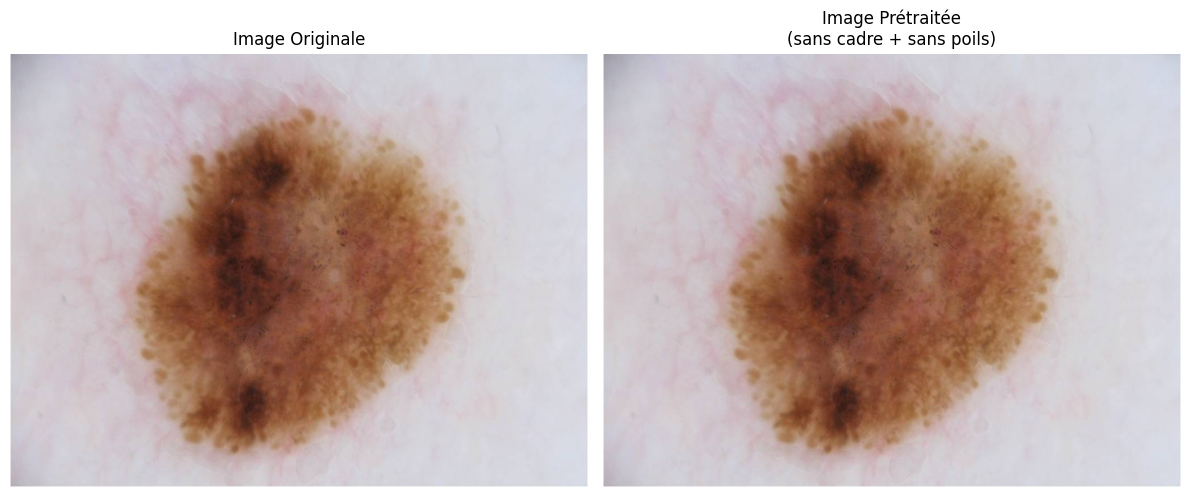

In [7]:
# Imports nécessaires
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
import os

# Charger une image de test
img_path = "../dataset/nevus/ISIC_0000008.jpg"
img_original = io.imread(img_path)

print(f"Image originale chargée: {img_original.shape}")
print(f"Type: {img_original.dtype}")

# Appliquer le prétraitement (suppression cadre noir + poils)
print("\n=== PRÉTRAITEMENT ===")
img = preprocess_image(img_original, remove_frame=True, remove_hair=True, verbose=True)
print(f"Image prétraitée: {img.shape}")

# Afficher les images avant/après prétraitement
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].imshow(img_original)
axes[0].set_title("Image Originale")
axes[0].axis('off')

axes[1].imshow(img)
axes[1].set_title("Image Prétraitée\n(sans cadre + sans poils)")
axes[1].axis('off')

plt.tight_layout()
plt.show()

## 1. Méthode Otsu Multi-Canal

SEGMENTATION OTSU MULTI-CANAL
Visualisation DÉTAILLÉE sauvegardée : otsu_multicanal_pipeline.jpg
Segmentation terminée !
Meilleur canal: Optimized
Forme du masque: (767, 1022)


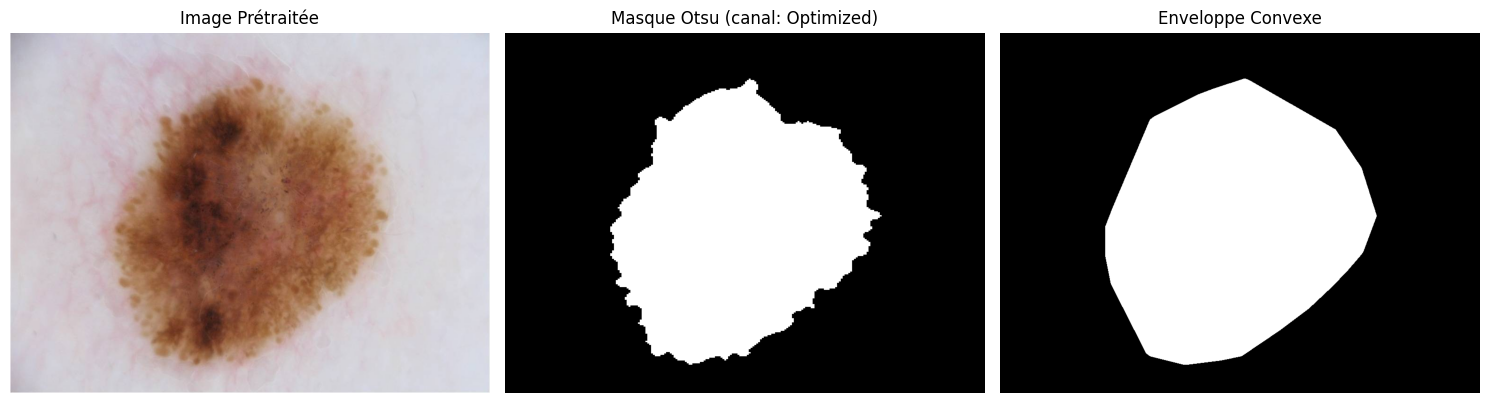

In [8]:
# MÉTHODE : OTSU MULTI-CANAL (APPLICATION)
print("SEGMENTATION OTSU MULTI-CANAL")

mask_otsu, convex_hull_otsu, results_otsu = otsu_multi_channel_segmentation(
    img,
    channels=['red', 'green', 'blue', 'gray'],
    disk_size=3,
    selection_method='composite_score',
    verbose=True
)

print("Segmentation terminée !")
print(f"Meilleur canal: {results_otsu['best_channel']}")
print(f"Forme du masque: {mask_otsu.shape}")

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(img)
axes[0].set_title("Image Prétraitée")
axes[0].axis('off')

axes[1].imshow(mask_otsu, cmap='gray')
axes[1].set_title(f"Masque Otsu (canal: {results_otsu['best_channel']})")
axes[1].axis('off')

axes[2].imshow(convex_hull_otsu, cmap='gray')
axes[2].set_title("Enveloppe Convexe")
axes[2].axis('off')

plt.tight_layout()
plt.show()

## 2. Méthode LBP Clustering

SEGMENTATION LBP CLUSTERING
Visualisation DÉTAILLÉE sauvegardée : lbp_pipeline.jpg
Segmentation terminée!
Forme du masque: (767, 1022)
Nombre de clusters: 2


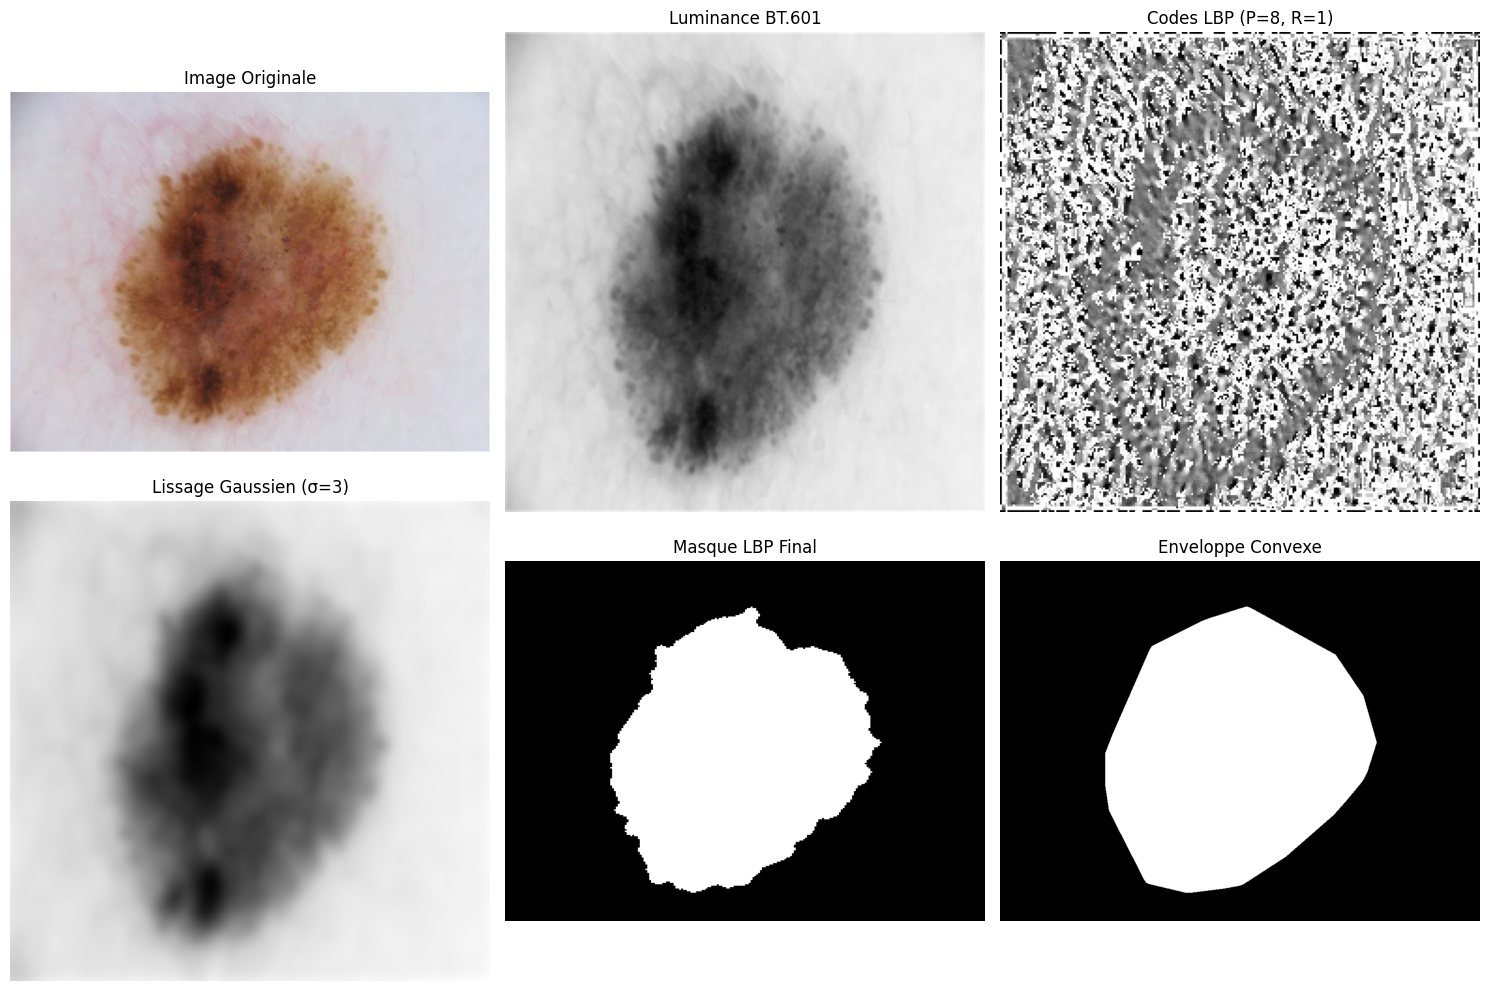

In [9]:
print("SEGMENTATION LBP CLUSTERING")

# Application de la méthode LBP avec prétraitement complet
mask_lbp, convex_hull_lbp, results_lbp = lbp_clustering_segmentation(
    img,
    sigma=3.0,
    disk_size=3,
    verbose=True
)

print(f"Segmentation terminée!")
print(f"Forme du masque: {mask_lbp.shape}")
print(f"Nombre de clusters: {len(np.unique(results_lbp['cluster_labels']))}")

# Visualisation
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Ligne 1: Pipeline principal
axes[0, 0].imshow(img)
axes[0, 0].set_title("Image Originale")
axes[0, 0].axis('off')

axes[0, 1].imshow(results_lbp['luminance'], cmap='gray')
axes[0, 1].set_title("Luminance BT.601")
axes[0, 1].axis('off')

axes[0, 2].imshow(results_lbp['lbp_codes'], cmap='gray')
axes[0, 2].set_title("Codes LBP (P=8, R=1)")
axes[0, 2].axis('off')

# Ligne 2: Résultats finaux
axes[1, 0].imshow(results_lbp['smoothed_L'], cmap='gray')
axes[1, 0].set_title("Lissage Gaussien (σ=3)")
axes[1, 0].axis('off')

axes[1, 1].imshow(mask_lbp, cmap='gray')
axes[1, 1].set_title("Masque LBP Final")
axes[1, 1].axis('off')

axes[1, 2].imshow(convex_hull_lbp, cmap='gray')
axes[1, 2].set_title("Enveloppe Convexe")
axes[1, 2].axis('off')

plt.tight_layout()
plt.show()

## 3. Méthode Statistical Region Merging (SRM)

SEGMENTATION STATISTICAL REGION MERGING
Visualisation DÉTAILLÉE sauvegardée : srm_pipeline.jpg
Segmentation terminée!
Nombre total de régions: 38
Région sélectionnée: [10, 12, 14, 15, 17, 18, 19, 21, 26, 27, 28, 29, 30, 31, 32, 33, 34]
Forme du masque: (767, 1022)


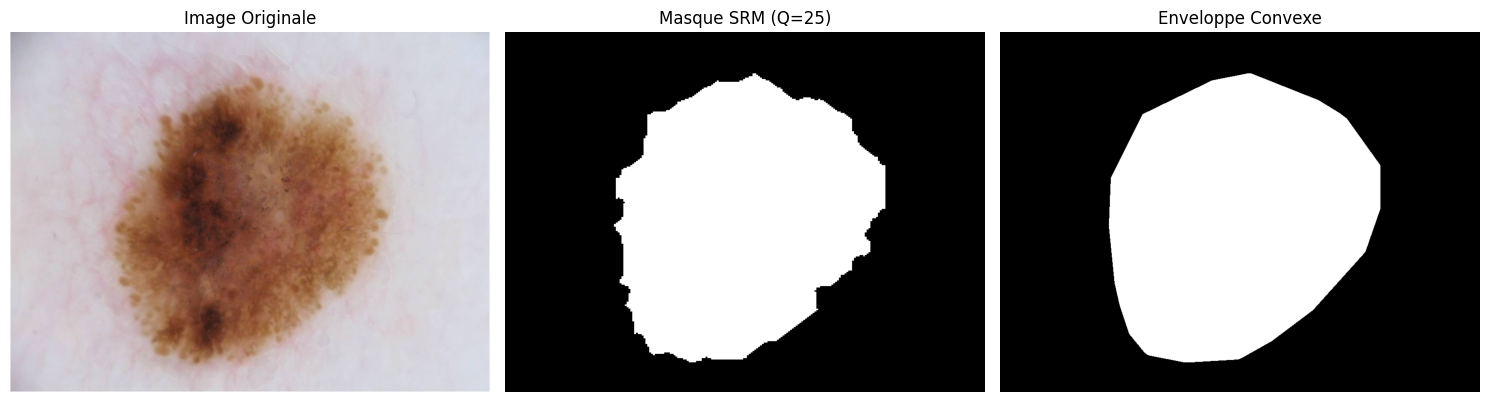

In [10]:
print("SEGMENTATION STATISTICAL REGION MERGING")

# Application de la méthode SRM avec post-traitement
# Réduire encore plus Q pour avoir BEAUCOUP moins de régions (fusion plus agressive)
mask_srm, convex_hull_srm, results_srm = srm_segmentation_with_postprocessing(
    img,
    Q=15,              # Paramètre d'échelle encore PLUS RÉDUIT (moins de régions)
    gaussian_sigma=2.0,  # Plus de lissage pour simplifier
    verbose=True        # Activer le mode verbose pour voir le scoring
)

print(f"Segmentation terminée!")
print(f"Nombre total de régions: {len(np.unique(results_srm['labels']))}")
print(f"Région sélectionnée: {results_srm['selected_region_label']}")
print(f"Forme du masque: {mask_srm.shape}")

# Visualisation
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(img)
axes[0].set_title("Image Originale")
axes[0].axis('off')

axes[1].imshow(mask_srm, cmap='gray')
axes[1].set_title(f"Masque SRM (Q=25)")
axes[1].axis('off')

axes[2].imshow(convex_hull_srm, cmap='gray')
axes[2].set_title("Enveloppe Convexe")
axes[2].axis('off')

plt.tight_layout()
plt.show()

## Comparaison Visuelle des 3 Méthodes

COMPARAISON DES 3 MÉTHODES


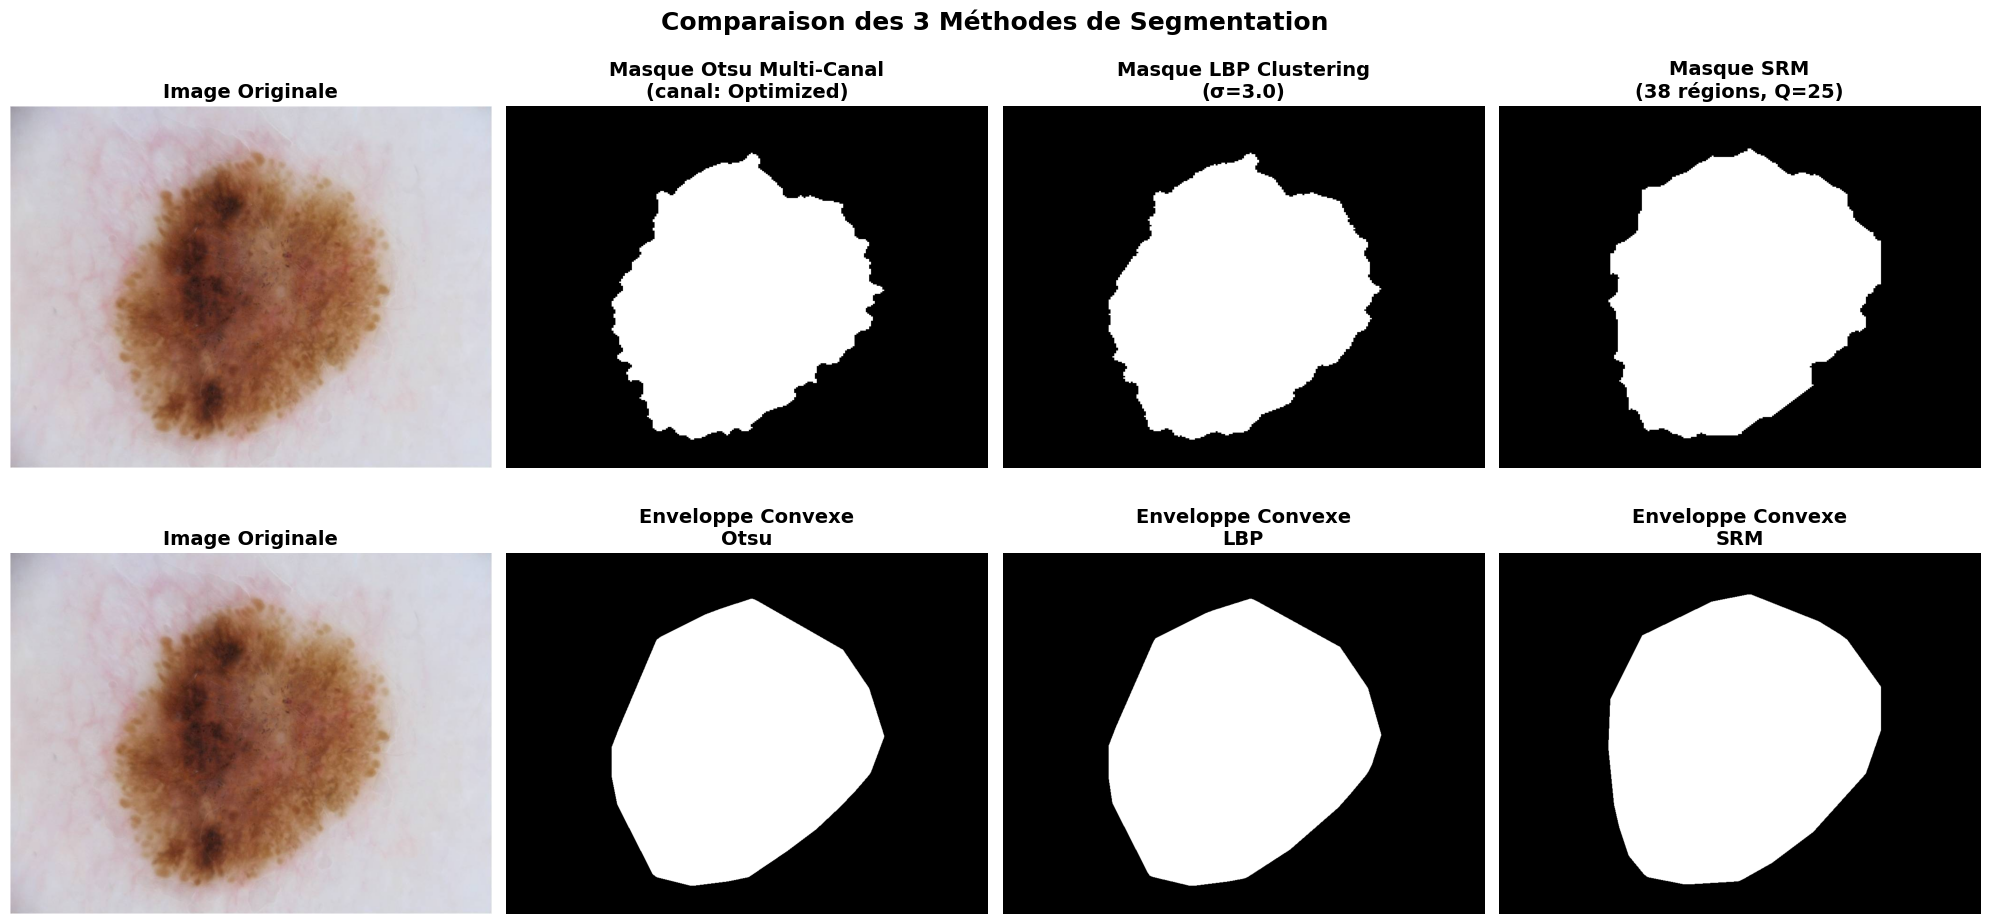

Comparaison terminée!


In [11]:
print("COMPARAISON DES 3 MÉTHODES")

# Visualisation comparative
fig, axes = plt.subplots(2, 4, figsize=(20, 10))

# Ligne 1: Image originale + 3 masques
axes[0, 0].imshow(img)
axes[0, 0].set_title("Image Originale", fontsize=14, fontweight='bold')
axes[0, 0].axis('off')

axes[0, 1].imshow(mask_otsu, cmap='gray')
axes[0, 1].set_title(f"Masque Otsu Multi-Canal\n(canal: {results_otsu['best_channel']})", 
                  fontsize=14, fontweight='bold')
axes[0, 1].axis('off')

axes[0, 2].imshow(mask_lbp, cmap='gray')
axes[0, 2].set_title(f"Masque LBP Clustering\n(σ=3.0)", 
                  fontsize=14, fontweight='bold')
axes[0, 2].axis('off')

axes[0, 3].imshow(mask_srm, cmap='gray')
axes[0, 3].set_title(f"Masque SRM\n({len(np.unique(results_srm['labels']))} régions, Q=25)", 
                  fontsize=14, fontweight='bold')
axes[0, 3].axis('off')

# Ligne 2: Enveloppes convexes
axes[1, 0].imshow(img)
axes[1, 0].set_title("Image Originale", fontsize=14, fontweight='bold')
axes[1, 0].axis('off')

axes[1, 1].imshow(convex_hull_otsu, cmap='gray')
axes[1, 1].set_title("Enveloppe Convexe\nOtsu", fontsize=14, fontweight='bold')
axes[1, 1].axis('off')

axes[1, 2].imshow(convex_hull_lbp, cmap='gray')
axes[1, 2].set_title("Enveloppe Convexe\nLBP", fontsize=14, fontweight='bold')
axes[1, 2].axis('off')

axes[1, 3].imshow(convex_hull_srm, cmap='gray')
axes[1, 3].set_title("Enveloppe Convexe\nSRM", fontsize=14, fontweight='bold')
axes[1, 3].axis('off')

plt.suptitle("Comparaison des 3 Méthodes de Segmentation", 
             fontsize=18, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

print("Comparaison terminée!")

In [12]:
# FONCTIONS D'ÉVALUATION (DICE & CHARGEMENT)
import os
import pandas as pd
import numpy as np
from skimage import io
from skimage.transform import resize


def compute_dice_score(mask_pred, mask_gt):
    """Calcule le coefficient de Dice entre deux masques binaires."""
    m1 = mask_pred > 0
    m2 = mask_gt > 0

    if m1.shape != m2.shape:
        m2 = resize(m2, m1.shape, order=0, mode="edge", anti_aliasing=False) > 0

    intersection = np.logical_and(m1, m2)

    if m1.sum() + m2.sum() == 0:
        return 1.0

    return 2.0 * intersection.sum() / (m1.sum() + m2.sum())


print("Fonctions Dice prêtes")

Fonctions Dice prêtes


In [13]:
# ==========================================
# CONFIGURATION DES CHEMINS DU DATASET
# ==========================================
from pathlib import Path

DATASET_ROOT = Path("../dataset").resolve()
DATASET_SUBFOLDERS = ["melanoma", "nevus"]

image_paths = []
for subset in DATASET_SUBFOLDERS:
    subset_dir = DATASET_ROOT / subset
    if not subset_dir.exists():
        print(f"⚠️ Dossier introuvable : {subset_dir}")
        continue

    subset_images = sorted(str(p) for p in subset_dir.glob("*.jpg"))
    if not subset_images:
        print(f"⚠️ Aucun fichier .jpg trouvé dans {subset_dir}")

    image_paths.extend(subset_images)

print(f"{len(image_paths)} images détectées dans {DATASET_ROOT}.")

20 images détectées dans C:\Users\theop\Documents\Telecom_Paris\2A\github\biomedical_segmentation\dataset.


In [14]:
# GÉNÉRATION DU RAPPORT PDF
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import pandas as pd
from skimage import io, morphology, feature, filters, segmentation, color
from skimage.measure import label, regionprops
from skimage.transform import resize
from skimage.segmentation import felzenszwalb
from sklearn.cluster import KMeans
from scipy.ndimage import binary_fill_holes
import numpy as np
import os

# 1) SMART HULL
def smart_hull(mask):
    """
    Calcule l'enveloppe convexe de manière intelligente :
    - Garde la plus grosse composante (le cœur).
    - Ne garde les petites taches annexes QUE si elles sont proches ou assez grosses.
    - Évite de relier un point de bruit isolé à l'autre bout de l'image (Fix ISIC 83).
    """
    if mask.sum() == 0: return mask
    
    # Étiquetage des composantes
    lab_img = label(mask)
    if lab_img.max() == 0: return mask
    
    props = regionprops(lab_img)
    # Trouver la composante principale (la plus grande)
    main_prop = max(props, key=lambda p: p.area)
    main_centroid = np.array(main_prop.centroid)
    
    # Masque filtré qui servira de base au Hull
    mask_kept = np.zeros_like(mask, dtype=bool)
    mask_kept[lab_img == main_prop.label] = True # On garde toujours le chef
    
    # On examine les autres petites taches
    for p in props:
        if p.label == main_prop.label: continue
        
        # Critère 1 : Taille relative (> 3% de la tache principale)
        # Si c'est assez gros (comme ISIC 150), on garde
        ratio_size = p.area / main_prop.area
        
        # Critère 2 : Distance relative
        # On calcule la distance entre les centres
        dist = np.linalg.norm(np.array(p.centroid) - main_centroid)
        # On compare par rapport au "rayon" approximatif de la tache principale
        radius_approx = np.sqrt(main_prop.area / np.pi)
        
        # ON GARDE SI : (Gros) OU (Très proche < 2.5 rayons)
        if ratio_size > 0.03 or dist < (radius_approx * 2.5):
            mask_kept[lab_img == p.label] = True
        # Sinon (petit point loin), on le laisse à False (supprimé) -> Fix ISIC 83
            
    # Calcul de l'enveloppe sur le masque nettoyé
    return morphology.convex_hull_image(mask_kept).astype(np.uint8)

# 2) FONCTION NETTOYAGE BASE
def force_clean_mask(mask):
    if mask.sum() == 0: return mask
    h, w = mask.shape
    cleaned = mask.copy()
    y, x = np.ogrid[:h, :w]
    cy, cx = h//2, w//2
    # Cercle sécurité
    mask_circle = (x - cx)**2 + (y - cy)**2 <= (min(h,w)//2 * 0.95)**2
    cleaned[~mask_circle] = 0
    # Anti-inversion
    if cleaned.mean() > 0.60:
        cleaned = 1 - cleaned
        cleaned[~mask_circle] = 0
    return cleaned # On laisse smart_hull gérer les composantes maintenant

# 3) TRAITEMENT
OUTPUT_PDF = "rapport_segmentation_final.pdf"
results = []

print(f"Traitement de {len(image_paths)} images... (Sortie: {OUTPUT_PDF})")

with PdfPages(OUTPUT_PDF) as pdf:
    for idx, img_path in enumerate(image_paths):
        
        # Chargement
        img_name = os.path.basename(img_path)
        try: img = io.imread(img_path)
        except: continue

        mask_name = img_name.replace('.jpg', '_Segmentation.png')
        # Derive mask directory from image path
        mask_dir = os.path.dirname(img_path)
        mask_path = os.path.join(mask_dir, mask_name)
        if not os.path.exists(mask_path):
            mask_path = os.path.join(mask_dir, img_name.replace('.jpg', '_segmentation.png'))
        if not os.path.exists(mask_path): continue
            
        gt_mask = io.imread(mask_path)
        if gt_mask.ndim == 3: gt_mask = gt_mask[:,:,0]
        gt_mask = (gt_mask > 127).astype(np.uint8)

        # Preprocess
        img_pre = preprocess_image(img, remove_frame=True, remove_hair=True, verbose=False)
        
        # Segment (On récupère les masques bruts)
        m_otsu, _, _ = otsu_multi_channel_segmentation(img_pre)
        m_lbp, _, _  = lbp_clustering_segmentation(img_pre)
        m_srm, _, _  = srm_segmentation_with_postprocessing(img_pre, Q=25)
        
        # Nettoyage de base (Coins / Inversion)
        m_otsu = force_clean_mask(m_otsu)
        m_lbp  = force_clean_mask(m_lbp)
        m_srm  = force_clean_mask(m_srm)
        
        # APPLI SMART HULL
        # C'est ici que ça décide si on relie les points ou pas
        ch_otsu = smart_hull(m_otsu)
        ch_lbp  = smart_hull(m_lbp)
        ch_srm  = smart_hull(m_srm)
        
        # Scores (Masques)
        d_otsu = compute_dice_score(m_otsu, gt_mask)
        d_lbp  = compute_dice_score(m_lbp, gt_mask)
        d_srm  = compute_dice_score(m_srm, gt_mask)

        # Scores (Hulls)
        d_ch_otsu = compute_dice_score(ch_otsu, gt_mask)
        d_ch_lbp  = compute_dice_score(ch_lbp, gt_mask)
        d_ch_srm  = compute_dice_score(ch_srm, gt_mask)
        
        # Meta
        cat = "Unknown"
        if 'metadata' in locals() and not metadata.empty:
            match = metadata.loc[metadata['image_id'] == img_name[:-4]]
            if not match.empty: cat = match['dx'].values[0]
            
        results.append({
            "Image": img_name, "Category": cat, 
            "Otsu": d_otsu, "Otsu_Hull": d_ch_otsu,
            "LBP": d_lbp, "LBP_Hull": d_ch_lbp,
            "SRM": d_srm, "SRM_Hull": d_ch_srm
        })

        # Plot
        fig, axes = plt.subplots(2, 4, figsize=(16, 8))
        plt.suptitle(f"{img_name} ({cat})", fontsize=14)
        
        def show(ax, im, title):
            ax.imshow(im, cmap='gray' if im.ndim==2 else None)
            ax.set_title(title, fontsize=10); ax.axis('off')

        show(axes[0,0], img, "Original")
        show(axes[0,1], gt_mask, "Ground Truth")
        show(axes[0,2], m_otsu, f"Otsu ({d_otsu:.2f})"); show(axes[1,2], ch_otsu, f"Otsu Hull ({d_ch_otsu:.2f})")
        show(axes[0,3], m_lbp, f"LBP ({d_lbp:.2f})"); show(axes[1,3], ch_lbp, f"LBP Hull ({d_ch_lbp:.2f})")
        show(axes[1,0], m_srm, f"SRM ({d_srm:.2f})"); show(axes[1,1], ch_srm, f"SRM Hull ({d_ch_srm:.2f})")
        
        plt.tight_layout()
        pdf.savefig(fig)
        plt.close(fig)
        print(f"[{idx+1}] {img_name} -> Otsu:{d_otsu:.2f} (H:{d_ch_otsu:.2f}) | LBP:{d_lbp:.2f} (H:{d_ch_lbp:.2f}) | SRM:{d_srm:.2f} (H:{d_ch_srm:.2f})")

if results:
    print("\n" + "="*30)
    print(pd.DataFrame(results)[["Otsu", "Otsu_Hull", "LBP", "LBP_Hull", "SRM", "SRM_Hull"]].mean())
    print(f"Terminé. Rapport : {OUTPUT_PDF}")

Traitement de 20 images... (Sortie: rapport_segmentation_final.pdf)


C:\Users\theop\AppData\Local\Temp\ipykernel_49348\1306177455.py:99: FutureWarning: `rectangle` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  s0 = morphology.rectangle(50,10)
C:\Users\theop\AppData\Local\Temp\ipykernel_49348\1306177455.py:100: FutureWarning: `rectangle` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  s1 = morphology.rectangle(10,50)
C:\Users\theop\AppData\Local\Temp\ipykernel_49348\1306177455.py:145: FutureWarning: `rectangle` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  square = morphology.rectangle(20, 20)
C:\Users\theop\AppData\Local\Temp\ipykernel_49348\1306177455.py:211: FutureWarning: `rectangle` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  square = 

Visualisation DÉTAILLÉE sauvegardée : otsu_multicanal_pipeline.jpg
Visualisation DÉTAILLÉE sauvegardée : lbp_pipeline.jpg
Visualisation DÉTAILLÉE sauvegardée : srm_pipeline.jpg
[1] ISIC_0000030.jpg -> Otsu:0.67 (H:0.75) | LBP:0.67 (H:0.76) | SRM:0.42 (H:0.58)


C:\Users\theop\AppData\Local\Temp\ipykernel_49348\1306177455.py:99: FutureWarning: `rectangle` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  s0 = morphology.rectangle(50,10)
C:\Users\theop\AppData\Local\Temp\ipykernel_49348\1306177455.py:100: FutureWarning: `rectangle` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  s1 = morphology.rectangle(10,50)
C:\Users\theop\AppData\Local\Temp\ipykernel_49348\1306177455.py:145: FutureWarning: `rectangle` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  square = morphology.rectangle(20, 20)


Visualisation DÉTAILLÉE sauvegardée : otsu_multicanal_pipeline.jpg
Visualisation DÉTAILLÉE sauvegardée : lbp_pipeline.jpg
Visualisation DÉTAILLÉE sauvegardée : srm_pipeline.jpg
[2] ISIC_0000046.jpg -> Otsu:0.89 (H:0.93) | LBP:0.91 (H:0.95) | SRM:0.70 (H:0.77)


C:\Users\theop\AppData\Local\Temp\ipykernel_49348\1306177455.py:99: FutureWarning: `rectangle` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  s0 = morphology.rectangle(50,10)
C:\Users\theop\AppData\Local\Temp\ipykernel_49348\1306177455.py:100: FutureWarning: `rectangle` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  s1 = morphology.rectangle(10,50)
C:\Users\theop\AppData\Local\Temp\ipykernel_49348\1306177455.py:145: FutureWarning: `rectangle` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  square = morphology.rectangle(20, 20)
C:\Users\theop\AppData\Local\Temp\ipykernel_49348\1306177455.py:211: FutureWarning: `rectangle` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  square = 

Visualisation DÉTAILLÉE sauvegardée : otsu_multicanal_pipeline.jpg
Visualisation DÉTAILLÉE sauvegardée : lbp_pipeline.jpg
Visualisation DÉTAILLÉE sauvegardée : srm_pipeline.jpg
[3] ISIC_0000049.jpg -> Otsu:0.62 (H:0.74) | LBP:0.64 (H:0.73) | SRM:0.84 (H:0.87)


C:\Users\theop\AppData\Local\Temp\ipykernel_49348\1306177455.py:99: FutureWarning: `rectangle` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  s0 = morphology.rectangle(50,10)
C:\Users\theop\AppData\Local\Temp\ipykernel_49348\1306177455.py:100: FutureWarning: `rectangle` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  s1 = morphology.rectangle(10,50)
C:\Users\theop\AppData\Local\Temp\ipykernel_49348\1306177455.py:145: FutureWarning: `rectangle` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  square = morphology.rectangle(20, 20)
C:\Users\theop\AppData\Local\Temp\ipykernel_49348\1306177455.py:211: FutureWarning: `rectangle` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  square = 

Visualisation DÉTAILLÉE sauvegardée : otsu_multicanal_pipeline.jpg
Visualisation DÉTAILLÉE sauvegardée : lbp_pipeline.jpg
Visualisation DÉTAILLÉE sauvegardée : srm_pipeline.jpg
[4] ISIC_0000140.jpg -> Otsu:0.91 (H:0.93) | LBP:0.91 (H:0.93) | SRM:0.91 (H:0.91)


C:\Users\theop\AppData\Local\Temp\ipykernel_49348\1306177455.py:99: FutureWarning: `rectangle` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  s0 = morphology.rectangle(50,10)
C:\Users\theop\AppData\Local\Temp\ipykernel_49348\1306177455.py:100: FutureWarning: `rectangle` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  s1 = morphology.rectangle(10,50)
C:\Users\theop\AppData\Local\Temp\ipykernel_49348\1306177455.py:145: FutureWarning: `rectangle` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  square = morphology.rectangle(20, 20)


Visualisation DÉTAILLÉE sauvegardée : otsu_multicanal_pipeline.jpg
Visualisation DÉTAILLÉE sauvegardée : lbp_pipeline.jpg
Visualisation DÉTAILLÉE sauvegardée : srm_pipeline.jpg
[5] ISIC_0000142.jpg -> Otsu:0.89 (H:0.92) | LBP:0.85 (H:0.88) | SRM:0.83 (H:0.92)


C:\Users\theop\AppData\Local\Temp\ipykernel_49348\1306177455.py:99: FutureWarning: `rectangle` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  s0 = morphology.rectangle(50,10)
C:\Users\theop\AppData\Local\Temp\ipykernel_49348\1306177455.py:100: FutureWarning: `rectangle` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  s1 = morphology.rectangle(10,50)
C:\Users\theop\AppData\Local\Temp\ipykernel_49348\1306177455.py:145: FutureWarning: `rectangle` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  square = morphology.rectangle(20, 20)


Visualisation DÉTAILLÉE sauvegardée : otsu_multicanal_pipeline.jpg
Visualisation DÉTAILLÉE sauvegardée : lbp_pipeline.jpg
Visualisation DÉTAILLÉE sauvegardée : srm_pipeline.jpg
[6] ISIC_0000143.jpg -> Otsu:0.71 (H:0.77) | LBP:0.72 (H:0.76) | SRM:0.81 (H:0.87)


C:\Users\theop\AppData\Local\Temp\ipykernel_49348\1306177455.py:99: FutureWarning: `rectangle` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  s0 = morphology.rectangle(50,10)
C:\Users\theop\AppData\Local\Temp\ipykernel_49348\1306177455.py:100: FutureWarning: `rectangle` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  s1 = morphology.rectangle(10,50)
C:\Users\theop\AppData\Local\Temp\ipykernel_49348\1306177455.py:145: FutureWarning: `rectangle` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  square = morphology.rectangle(20, 20)


Visualisation DÉTAILLÉE sauvegardée : otsu_multicanal_pipeline.jpg
Visualisation DÉTAILLÉE sauvegardée : lbp_pipeline.jpg
Visualisation DÉTAILLÉE sauvegardée : srm_pipeline.jpg
[7] ISIC_0000145.jpg -> Otsu:0.99 (H:0.98) | LBP:0.99 (H:0.98) | SRM:0.96 (H:0.96)


C:\Users\theop\AppData\Local\Temp\ipykernel_49348\1306177455.py:99: FutureWarning: `rectangle` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  s0 = morphology.rectangle(50,10)
C:\Users\theop\AppData\Local\Temp\ipykernel_49348\1306177455.py:100: FutureWarning: `rectangle` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  s1 = morphology.rectangle(10,50)
C:\Users\theop\AppData\Local\Temp\ipykernel_49348\1306177455.py:145: FutureWarning: `rectangle` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  square = morphology.rectangle(20, 20)


Visualisation DÉTAILLÉE sauvegardée : otsu_multicanal_pipeline.jpg
Visualisation DÉTAILLÉE sauvegardée : lbp_pipeline.jpg
Visualisation DÉTAILLÉE sauvegardée : srm_pipeline.jpg
[8] ISIC_0000146.jpg -> Otsu:0.91 (H:0.93) | LBP:0.90 (H:0.93) | SRM:0.85 (H:0.91)


C:\Users\theop\AppData\Local\Temp\ipykernel_49348\1306177455.py:99: FutureWarning: `rectangle` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  s0 = morphology.rectangle(50,10)
C:\Users\theop\AppData\Local\Temp\ipykernel_49348\1306177455.py:100: FutureWarning: `rectangle` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  s1 = morphology.rectangle(10,50)
C:\Users\theop\AppData\Local\Temp\ipykernel_49348\1306177455.py:145: FutureWarning: `rectangle` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  square = morphology.rectangle(20, 20)


Visualisation DÉTAILLÉE sauvegardée : otsu_multicanal_pipeline.jpg
Visualisation DÉTAILLÉE sauvegardée : lbp_pipeline.jpg
Visualisation DÉTAILLÉE sauvegardée : srm_pipeline.jpg
[9] ISIC_0000150.jpg -> Otsu:0.81 (H:0.94) | LBP:0.77 (H:0.89) | SRM:0.85 (H:0.92)


C:\Users\theop\AppData\Local\Temp\ipykernel_49348\1306177455.py:99: FutureWarning: `rectangle` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  s0 = morphology.rectangle(50,10)
C:\Users\theop\AppData\Local\Temp\ipykernel_49348\1306177455.py:100: FutureWarning: `rectangle` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  s1 = morphology.rectangle(10,50)
C:\Users\theop\AppData\Local\Temp\ipykernel_49348\1306177455.py:145: FutureWarning: `rectangle` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  square = morphology.rectangle(20, 20)


Visualisation DÉTAILLÉE sauvegardée : otsu_multicanal_pipeline.jpg
Visualisation DÉTAILLÉE sauvegardée : lbp_pipeline.jpg
Visualisation DÉTAILLÉE sauvegardée : srm_pipeline.jpg
[10] ISIC_0000151.jpg -> Otsu:0.83 (H:0.87) | LBP:0.85 (H:0.88) | SRM:0.92 (H:0.89)


C:\Users\theop\AppData\Local\Temp\ipykernel_49348\1306177455.py:99: FutureWarning: `rectangle` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  s0 = morphology.rectangle(50,10)
C:\Users\theop\AppData\Local\Temp\ipykernel_49348\1306177455.py:100: FutureWarning: `rectangle` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  s1 = morphology.rectangle(10,50)
C:\Users\theop\AppData\Local\Temp\ipykernel_49348\1306177455.py:145: FutureWarning: `rectangle` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  square = morphology.rectangle(20, 20)


Visualisation DÉTAILLÉE sauvegardée : otsu_multicanal_pipeline.jpg
Visualisation DÉTAILLÉE sauvegardée : lbp_pipeline.jpg
Visualisation DÉTAILLÉE sauvegardée : srm_pipeline.jpg
[11] ISIC_0000000.jpg -> Otsu:0.90 (H:0.92) | LBP:0.91 (H:0.93) | SRM:0.89 (H:0.92)


C:\Users\theop\AppData\Local\Temp\ipykernel_49348\1306177455.py:99: FutureWarning: `rectangle` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  s0 = morphology.rectangle(50,10)
C:\Users\theop\AppData\Local\Temp\ipykernel_49348\1306177455.py:100: FutureWarning: `rectangle` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  s1 = morphology.rectangle(10,50)
C:\Users\theop\AppData\Local\Temp\ipykernel_49348\1306177455.py:145: FutureWarning: `rectangle` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  square = morphology.rectangle(20, 20)


Visualisation DÉTAILLÉE sauvegardée : otsu_multicanal_pipeline.jpg
Visualisation DÉTAILLÉE sauvegardée : lbp_pipeline.jpg
Visualisation DÉTAILLÉE sauvegardée : srm_pipeline.jpg
[12] ISIC_0000001.jpg -> Otsu:0.98 (H:0.96) | LBP:0.98 (H:0.96) | SRM:0.90 (H:0.87)


C:\Users\theop\AppData\Local\Temp\ipykernel_49348\1306177455.py:99: FutureWarning: `rectangle` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  s0 = morphology.rectangle(50,10)
C:\Users\theop\AppData\Local\Temp\ipykernel_49348\1306177455.py:100: FutureWarning: `rectangle` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  s1 = morphology.rectangle(10,50)
C:\Users\theop\AppData\Local\Temp\ipykernel_49348\1306177455.py:145: FutureWarning: `rectangle` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  square = morphology.rectangle(20, 20)


Visualisation DÉTAILLÉE sauvegardée : otsu_multicanal_pipeline.jpg
Visualisation DÉTAILLÉE sauvegardée : lbp_pipeline.jpg
Visualisation DÉTAILLÉE sauvegardée : srm_pipeline.jpg
[13] ISIC_0000008.jpg -> Otsu:0.93 (H:0.97) | LBP:0.95 (H:0.97) | SRM:0.89 (H:0.93)


C:\Users\theop\AppData\Local\Temp\ipykernel_49348\1306177455.py:99: FutureWarning: `rectangle` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  s0 = morphology.rectangle(50,10)
C:\Users\theop\AppData\Local\Temp\ipykernel_49348\1306177455.py:100: FutureWarning: `rectangle` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  s1 = morphology.rectangle(10,50)
C:\Users\theop\AppData\Local\Temp\ipykernel_49348\1306177455.py:145: FutureWarning: `rectangle` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  square = morphology.rectangle(20, 20)


Visualisation DÉTAILLÉE sauvegardée : otsu_multicanal_pipeline.jpg
Visualisation DÉTAILLÉE sauvegardée : lbp_pipeline.jpg
Visualisation DÉTAILLÉE sauvegardée : srm_pipeline.jpg
[14] ISIC_0000019.jpg -> Otsu:0.87 (H:0.91) | LBP:0.89 (H:0.92) | SRM:0.82 (H:0.86)


C:\Users\theop\AppData\Local\Temp\ipykernel_49348\1306177455.py:99: FutureWarning: `rectangle` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  s0 = morphology.rectangle(50,10)
C:\Users\theop\AppData\Local\Temp\ipykernel_49348\1306177455.py:100: FutureWarning: `rectangle` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  s1 = morphology.rectangle(10,50)
C:\Users\theop\AppData\Local\Temp\ipykernel_49348\1306177455.py:145: FutureWarning: `rectangle` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  square = morphology.rectangle(20, 20)


Visualisation DÉTAILLÉE sauvegardée : otsu_multicanal_pipeline.jpg
Visualisation DÉTAILLÉE sauvegardée : lbp_pipeline.jpg
Visualisation DÉTAILLÉE sauvegardée : srm_pipeline.jpg
[15] ISIC_0000024.jpg -> Otsu:0.65 (H:0.90) | LBP:0.70 (H:0.78) | SRM:0.18 (H:0.55)


C:\Users\theop\AppData\Local\Temp\ipykernel_49348\1306177455.py:99: FutureWarning: `rectangle` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  s0 = morphology.rectangle(50,10)
C:\Users\theop\AppData\Local\Temp\ipykernel_49348\1306177455.py:100: FutureWarning: `rectangle` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  s1 = morphology.rectangle(10,50)
C:\Users\theop\AppData\Local\Temp\ipykernel_49348\1306177455.py:145: FutureWarning: `rectangle` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  square = morphology.rectangle(20, 20)
C:\Users\theop\AppData\Local\Temp\ipykernel_49348\1306177455.py:211: FutureWarning: `rectangle` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  square = 

Visualisation DÉTAILLÉE sauvegardée : otsu_multicanal_pipeline.jpg
Visualisation DÉTAILLÉE sauvegardée : lbp_pipeline.jpg
Visualisation DÉTAILLÉE sauvegardée : srm_pipeline.jpg
[16] ISIC_0000042.jpg -> Otsu:0.80 (H:0.86) | LBP:0.82 (H:0.88) | SRM:0.87 (H:0.90)


C:\Users\theop\AppData\Local\Temp\ipykernel_49348\1306177455.py:99: FutureWarning: `rectangle` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  s0 = morphology.rectangle(50,10)
C:\Users\theop\AppData\Local\Temp\ipykernel_49348\1306177455.py:100: FutureWarning: `rectangle` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  s1 = morphology.rectangle(10,50)
C:\Users\theop\AppData\Local\Temp\ipykernel_49348\1306177455.py:145: FutureWarning: `rectangle` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  square = morphology.rectangle(20, 20)
C:\Users\theop\AppData\Local\Temp\ipykernel_49348\1306177455.py:211: FutureWarning: `rectangle` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  square = 

Visualisation DÉTAILLÉE sauvegardée : otsu_multicanal_pipeline.jpg
Visualisation DÉTAILLÉE sauvegardée : lbp_pipeline.jpg
Visualisation DÉTAILLÉE sauvegardée : srm_pipeline.jpg
[17] ISIC_0000045.jpg -> Otsu:0.95 (H:0.96) | LBP:0.95 (H:0.96) | SRM:0.91 (H:0.96)


C:\Users\theop\AppData\Local\Temp\ipykernel_49348\1306177455.py:99: FutureWarning: `rectangle` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  s0 = morphology.rectangle(50,10)
C:\Users\theop\AppData\Local\Temp\ipykernel_49348\1306177455.py:100: FutureWarning: `rectangle` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  s1 = morphology.rectangle(10,50)
C:\Users\theop\AppData\Local\Temp\ipykernel_49348\1306177455.py:145: FutureWarning: `rectangle` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  square = morphology.rectangle(20, 20)


Visualisation DÉTAILLÉE sauvegardée : otsu_multicanal_pipeline.jpg
Visualisation DÉTAILLÉE sauvegardée : lbp_pipeline.jpg
Visualisation DÉTAILLÉE sauvegardée : srm_pipeline.jpg
[18] ISIC_0000080.jpg -> Otsu:0.94 (H:0.96) | LBP:0.96 (H:0.97) | SRM:0.89 (H:0.87)


C:\Users\theop\AppData\Local\Temp\ipykernel_49348\1306177455.py:99: FutureWarning: `rectangle` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  s0 = morphology.rectangle(50,10)
C:\Users\theop\AppData\Local\Temp\ipykernel_49348\1306177455.py:100: FutureWarning: `rectangle` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  s1 = morphology.rectangle(10,50)
C:\Users\theop\AppData\Local\Temp\ipykernel_49348\1306177455.py:145: FutureWarning: `rectangle` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  square = morphology.rectangle(20, 20)
C:\Users\theop\AppData\Local\Temp\ipykernel_49348\1306177455.py:211: FutureWarning: `rectangle` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  square = 

Visualisation DÉTAILLÉE sauvegardée : otsu_multicanal_pipeline.jpg
Visualisation DÉTAILLÉE sauvegardée : lbp_pipeline.jpg
Visualisation DÉTAILLÉE sauvegardée : srm_pipeline.jpg
[19] ISIC_0000095.jpg -> Otsu:0.86 (H:0.90) | LBP:0.91 (H:0.95) | SRM:0.94 (H:0.91)


C:\Users\theop\AppData\Local\Temp\ipykernel_49348\1306177455.py:99: FutureWarning: `rectangle` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  s0 = morphology.rectangle(50,10)
C:\Users\theop\AppData\Local\Temp\ipykernel_49348\1306177455.py:100: FutureWarning: `rectangle` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  s1 = morphology.rectangle(10,50)
C:\Users\theop\AppData\Local\Temp\ipykernel_49348\1306177455.py:145: FutureWarning: `rectangle` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  square = morphology.rectangle(20, 20)


Visualisation DÉTAILLÉE sauvegardée : otsu_multicanal_pipeline.jpg
Visualisation DÉTAILLÉE sauvegardée : lbp_pipeline.jpg
Visualisation DÉTAILLÉE sauvegardée : srm_pipeline.jpg
[20] ISIC_0000112.jpg -> Otsu:0.76 (H:0.85) | LBP:0.80 (H:0.87) | SRM:0.86 (H:0.91)

Otsu         0.844238
Otsu_Hull    0.897528
LBP          0.853385
LBP_Hull     0.893043
SRM          0.811228
SRM_Hull     0.864984
dtype: float64
Terminé. Rapport : rapport_segmentation_final.pdf


Images Melanoma : 10
Images Nevus    : 10


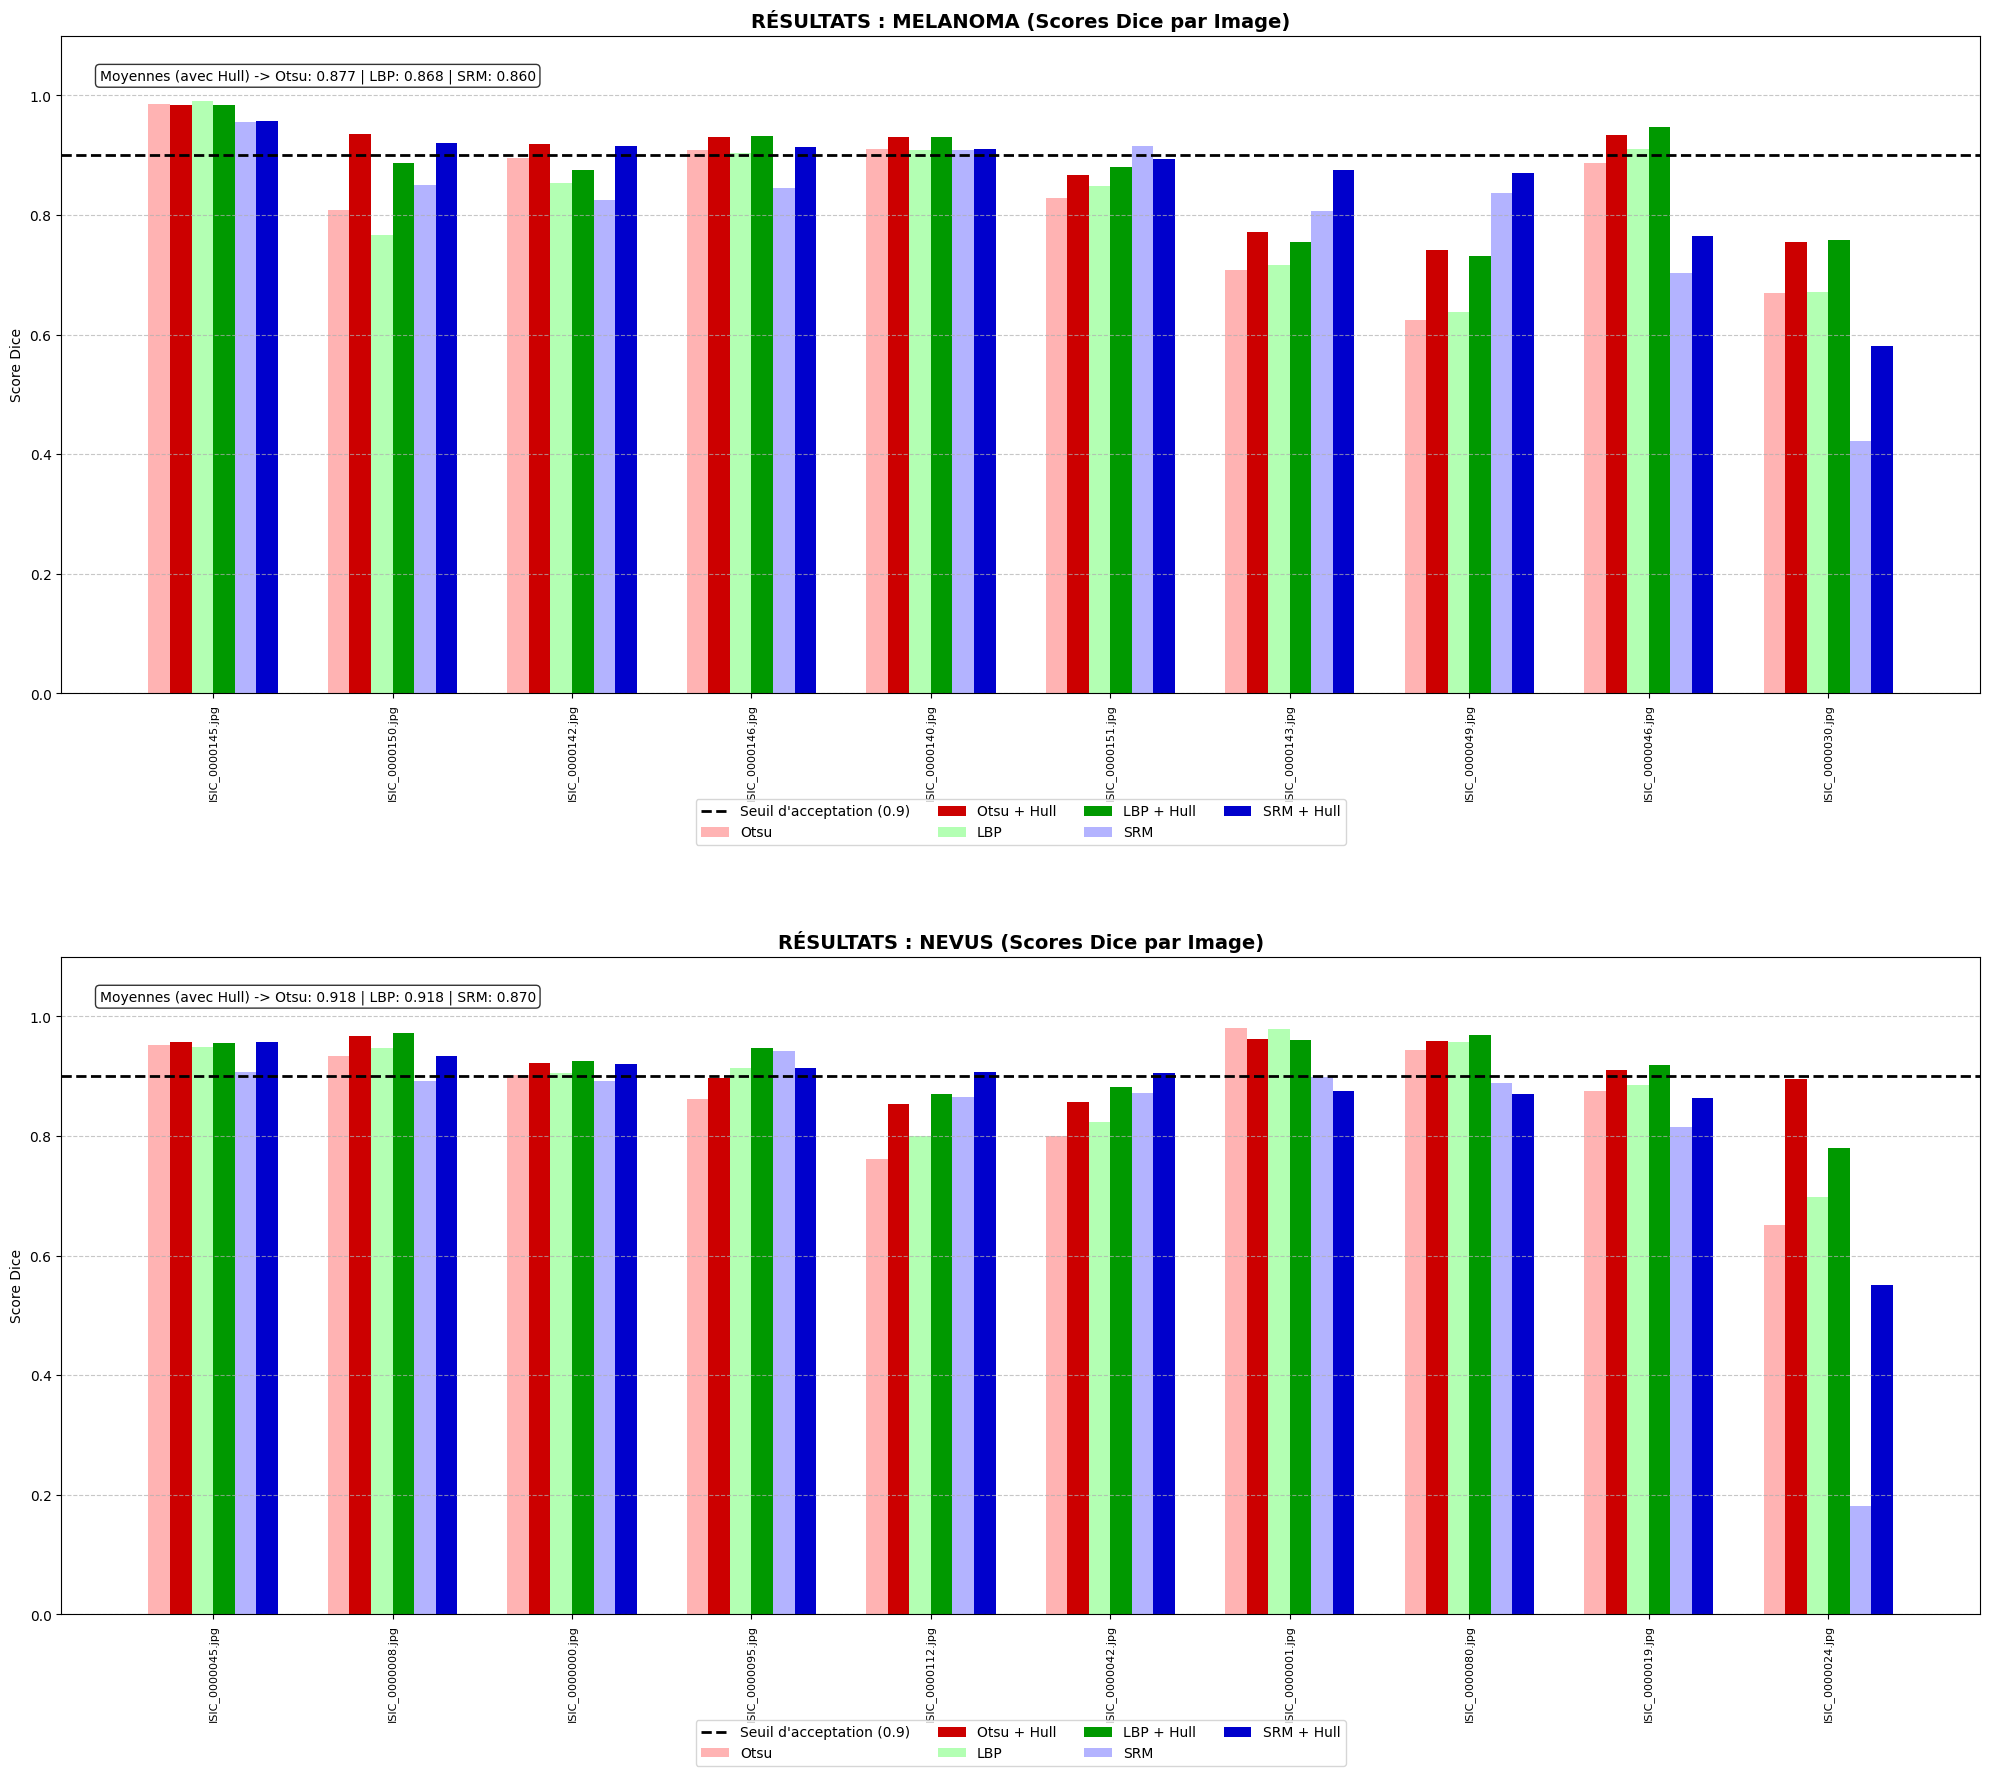

✅ Graphiques d'analyse sauvegardés dans : c:\Users\theop\Documents\Telecom_Paris\2A\github\biomedical_segmentation\rendu_final\analyse_dice_scores_melanoma_nevus.pdf

=== TABLEAU RÉCAPITULATIF DES MOYENNES ===
              Otsu  Otsu_Hull       LBP  LBP_Hull       SRM  SRM_Hull
Category                                                             
melanoma  0.822555   0.877014  0.820924  0.868144  0.807200  0.860398
nevus     0.865920   0.918042  0.885846  0.917942  0.815257  0.869570


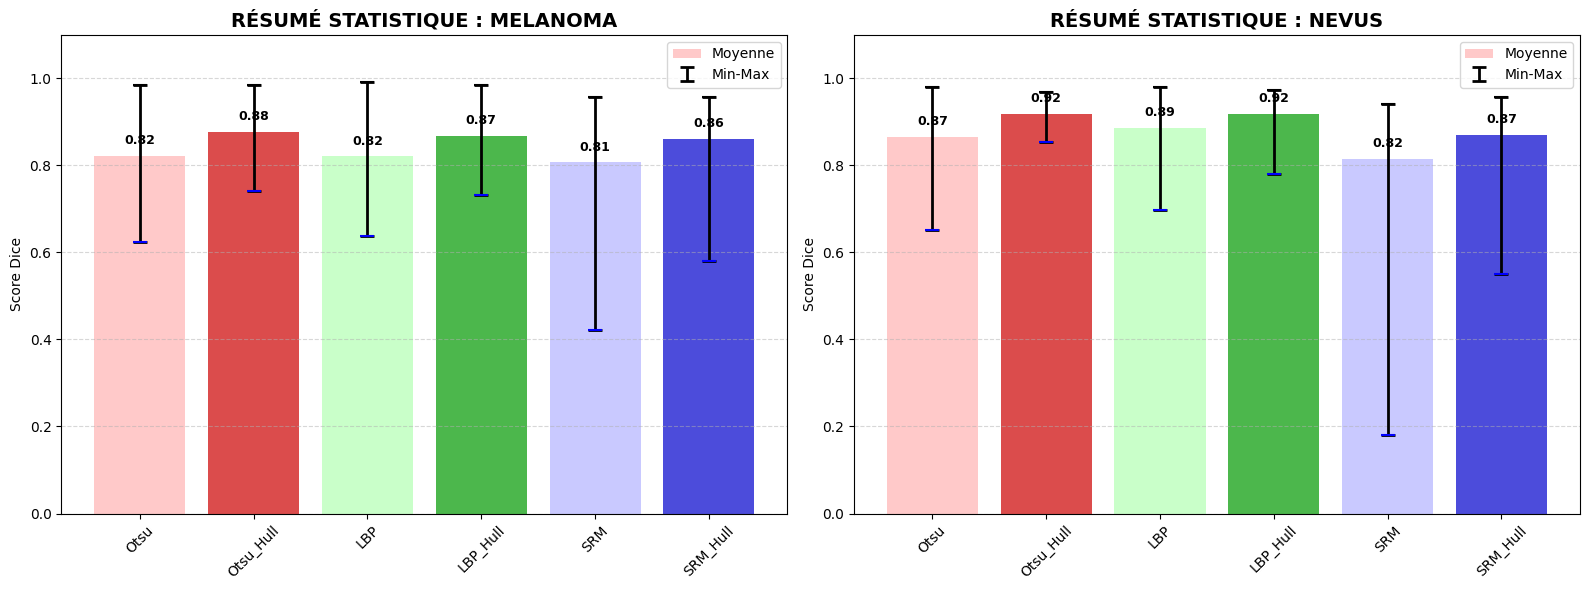

✅ Graphique résumé sauvegardé dans : c:\Users\theop\Documents\Telecom_Paris\2A\github\biomedical_segmentation\rendu_final\analyse_resume_stats.pdf


In [15]:
# ANALYSE GRAPHIQUE DES RÉSULTATS (MELANOMA vs NEVUS)
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

# Vérification de la présence des résultats
if 'results' not in locals() or not results:
    print("⚠️ Erreur : La variable 'results' est vide ou inexistante. Veuillez exécuter la cellule précédente pour générer les scores.")
else:
    # Conversion en DataFrame
    df = pd.DataFrame(results)
    
    # Tentative de récupération des catégories si "Unknown" (basé sur le chemin du fichier)
    if 'Category' in df.columns and (df['Category'] == 'Unknown').any() and 'image_paths' in locals():
        name_to_cat = {}
        for p in image_paths:
            fname = os.path.basename(p)
            if 'melanoma' in p.lower():
                name_to_cat[fname] = 'melanoma'
            elif 'nevus' in p.lower():
                name_to_cat[fname] = 'nevus'
        
        # Mise à jour de la colonne Category
        df['Category'] = df.apply(lambda row: name_to_cat.get(row['Image'], row['Category']), axis=1)

    # Séparation des datasets
    df_mel = df[df['Category'].astype(str).str.lower() == 'melanoma'].copy()
    df_nev = df[df['Category'].astype(str).str.lower() == 'nevus'].copy()
    
    print(f"Images Melanoma : {len(df_mel)}")
    print(f"Images Nevus    : {len(df_nev)}")

    # Fonction de tracé
    def plot_dataset_scores(data, title, ax):
        if data.empty:
            ax.text(0.5, 0.5, "Aucune donnée disponible", ha='center', fontsize=12)
            ax.set_title(title)
            return
        
        # Tri par score SRM Hull décroissant pour la lisibilité
        data = data.sort_values('SRM_Hull', ascending=False)
        
        images = data['Image']
        x = np.arange(len(images))
        width = 0.12  # Largeur des barres
        
        # Couleurs (Pastel pour sans Hull, Vif pour avec Hull)
        colors = {
            'Otsu': '#ffb3b3', 'Otsu_Hull': '#cc0000',
            'LBP': '#b3ffb3',  'LBP_Hull': '#009900',
            'SRM': '#b3b3ff',  'SRM_Hull': '#0000cc'
        }
        
        # Tracé des barres
        rects1 = ax.bar(x - 2.5*width, data['Otsu'], width, label='Otsu', color=colors['Otsu'])
        rects2 = ax.bar(x - 1.5*width, data['Otsu_Hull'], width, label='Otsu + Hull', color=colors['Otsu_Hull'])
        
        rects3 = ax.bar(x - 0.5*width, data['LBP'], width, label='LBP', color=colors['LBP'])
        rects4 = ax.bar(x + 0.5*width, data['LBP_Hull'], width, label='LBP + Hull', color=colors['LBP_Hull'])
        
        rects5 = ax.bar(x + 1.5*width, data['SRM'], width, label='SRM', color=colors['SRM'])
        rects6 = ax.bar(x + 2.5*width, data['SRM_Hull'], width, label='SRM + Hull', color=colors['SRM_Hull'])
        
        # Ligne de seuil à 0.9
        ax.axhline(y=0.9, color='black', linestyle='--', linewidth=2, label='Seuil d\'acceptation (0.9)')
        
        # Mise en forme
        ax.set_ylabel('Score Dice')
        ax.set_title(title, fontsize=14, fontweight='bold')
        ax.set_xticks(x)
        ax.set_xticklabels(images, rotation=90, fontsize=8)
        ax.set_ylim(0, 1.1)
        ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4, fontsize=10)
        ax.grid(axis='y', linestyle='--', alpha=0.7)
        
        # Affichage des stats moyennes dans le titre ou sous-titre
        means = data[["Otsu_Hull", "LBP_Hull", "SRM_Hull"]].mean()
        stats_text = f"Moyennes (avec Hull) -> Otsu: {means['Otsu_Hull']:.3f} | LBP: {means['LBP_Hull']:.3f} | SRM: {means['SRM_Hull']:.3f}"
        ax.text(0.02, 0.95, stats_text, transform=ax.transAxes, fontsize=10, 
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    # Création de la figure
    fig, axes = plt.subplots(2, 1, figsize=(20, 18))
    
    plot_dataset_scores(df_mel, "RÉSULTATS : MELANOMA (Scores Dice par Image)", axes[0])
    plot_dataset_scores(df_nev, "RÉSULTATS : NEVUS (Scores Dice par Image)", axes[1])
    
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.1, hspace=0.4)
    
    # Sauvegarde
    output_graph = "analyse_dice_scores_melanoma_nevus.pdf"
    plt.savefig(output_graph, dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"✅ Graphiques d'analyse sauvegardés dans : {os.path.abspath(output_graph)}")
    
    # Affichage tableau résumé
    print("\n=== TABLEAU RÉCAPITULATIF DES MOYENNES ===")
    summary = df.groupby('Category')[["Otsu", "Otsu_Hull", "LBP", "LBP_Hull", "SRM", "SRM_Hull"]].mean()
    print(summary)


    # NOUVEAU GRAPHIQUE : RÉSUMÉ STATISTIQUE (MIN, MOYENNE, MAX)
    
    def plot_summary_stats(data, title, ax):
        if data.empty: return
        
        methods = ['Otsu', 'Otsu_Hull', 'LBP', 'LBP_Hull', 'SRM', 'SRM_Hull']
        means = data[methods].mean()
        mins = data[methods].min()
        maxs = data[methods].max()
        
        x = np.arange(len(methods))
        
        # Barres pour la moyenne
        bars = ax.bar(x, means, color=['#ffb3b3', '#cc0000', '#b3ffb3', '#009900', '#b3b3ff', '#0000cc'], alpha=0.7, label='Moyenne')
        
        # Lignes pour Min-Max
        ax.errorbar(x, means, yerr=[means - mins, maxs - means], fmt='none', ecolor='black', capsize=5, elinewidth=2, markeredgewidth=2, label='Min-Max')
        
        # Points pour Min et Max
        ax.scatter(x, mins, color='blue', marker='_', s=100, zorder=3)
        ax.scatter(x, maxs, color='black', marker='_', s=100, zorder=3)
        
        # Labels
        ax.set_ylabel('Score Dice')
        ax.set_title(title, fontsize=14, fontweight='bold')
        ax.set_xticks(x)
        ax.set_xticklabels(methods, rotation=45)
        ax.set_ylim(0, 1.1)
        ax.grid(axis='y', linestyle='--', alpha=0.5)
        ax.legend()
        
        # Annotations des valeurs moyennes
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                    f'{height:.2f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

    # Création de la figure de résumé
    fig_summary, axes_summary = plt.subplots(1, 2, figsize=(16, 6))
    
    plot_summary_stats(df_mel, "RÉSUMÉ STATISTIQUE : MELANOMA", axes_summary[0])
    plot_summary_stats(df_nev, "RÉSUMÉ STATISTIQUE : NEVUS", axes_summary[1])
    
    plt.tight_layout()
    
    # Sauvegarde
    output_summary = "analyse_resume_stats.pdf"
    plt.savefig(output_summary, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"✅ Graphique résumé sauvegardé dans : {os.path.abspath(output_summary)}")